In [45]:
par_log_transform = True

In [46]:
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse
from utils.fim_utils import computeCriteria, logTransform
rc('text', usetex=True)

In [47]:
with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/bursting_parameters.npz') as par:
    kon = par['kon']
    koff = par['koff']
    alpha = par['alpha']
    gamma = par['gamma']

theta = np.array([kon, koff, alpha, gamma])

In [48]:
fim_single_cell = dict()

for s in ["exact", "binomial", "lowres"]:
    with np.load(f'results/fim_{s}.npz') as data:
        fim_single_cell[s] = data['fim']

if par_log_transform:
    for fim in fim_single_cell.values():
        logTransform(fim, theta)

## Monte Carlo estimates for flowcytometry FIM

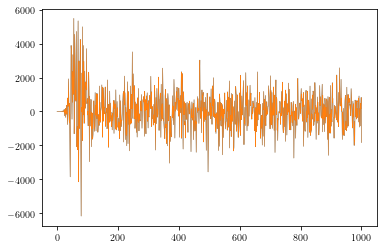

In [49]:
with np.load(f'results/fim_flowcyt.npz') as _:
    fim_flowcyts = _['fim']
fig = plt.figure()
ax = fig.add_subplot()
for i in range(fim_flowcyts.shape[0]):
    y = computeCriteria(fim_flowcyts[i, ...])
    ax.plot(y, linewidth=0.5)
fim_flowcyt = np.mean(fim_flowcyts, axis=0)
logTransform(fim_flowcyt, theta)
fim_single_cell["flowcyt"] = fim_flowcyt

## D-optimal sampling periods for different types of measurements

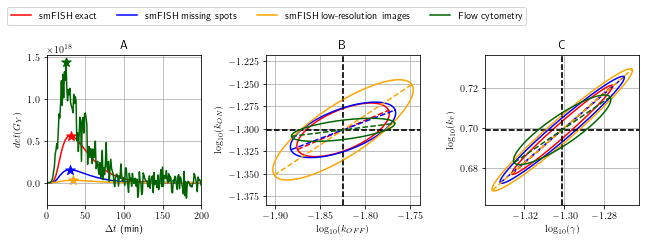

In [61]:
ncells_smfish = 1000
ncells_flowcyt = 10000

fim_multi_cells = dict()

for meas_type in fim_single_cell.keys():
    fim_multi_cells[meas_type] = ncells_smfish*fim_single_cell[meas_type]
fim_multi_cells['flowcyt'] = ncells_flowcyt*fim_single_cell['flowcyt']

def compute_combined_fim(fim_array, dt, num_times):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += fim_array[t_idx[i], :, :]
    return fim

num_times = 5
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

fim_multi_cells_times = dict()
det_fim_multi_cells_times = dict()

for meas_type in fim_multi_cells.keys():
    combined_fim = np.zeros((len(dt_array), 4, 4))
    det_comb_fim = np.zeros((len(dt_array),))

    for i in range(0, len(dt_array)):
        combined_fim[i, :, :] = compute_combined_fim(fim_multi_cells[meas_type], dt_array[i],  num_times)
        det_comb_fim[i] = np.linalg.det(combined_fim[i,:,:])

    fim_multi_cells_times[meas_type] = combined_fim
    det_fim_multi_cells_times[meas_type] = det_comb_fim
#
opt_rates = dict()
for meas in fim_multi_cells_times.keys():
    opt_rates[meas] = np.argmax(det_fim_multi_cells_times[meas])

DT_MAX = 200
labels = {
        'exact': f'smFISH exact',
        'binomial': f'smFISH missing spots',
        'lowres': f'smFISH low-resolution images',
        'flowcyt': f'Flow cytometry',
}

colors = {
        'exact': f'red',
        'binomial': f'blue',
        'lowres': f'orange',
        'flowcyt': f'darkgreen',
}
    
fig, axs = plt.subplots(1,3)
fig.set_size_inches(9, 3)
fig.set_tight_layout(True)
for meas in ['exact', 'binomial', 'lowres', 'flowcyt']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    
    axs[0].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[0].scatter(dt_array[idx_opt],
                   dets[idx_opt],
               100,
               color=colors[meas],
                   marker='*')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[1],
                      [1,0],
                      theta,
                      colors[meas], '')
    plot_conf_ellipse(fims[idx_opt],
                      3,
                      axs[2],
                      [3,2],
                      theta, colors[meas], '')

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower left', ncol=5)
axs[0].set_xlim([0, DT_MAX])
axs[0].set_xlabel('$\Delta t$ (min)')
axs[0].set_ylabel('$\mathop{det}(G_Y)$')

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')    
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')    
axs[2].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs):
    ax.grid()

axs[0].set_title('A')
axs[1].set_title('B')
axs[2].set_title('C')

fig.savefig('figs/fim_dopt.pdf', bbox_inches='tight')

## Find the optimal mixture of smFISH and flow cytomtery experiments at 45 minutes under budget constraints

In [51]:
BUDGET_MAX = 1000.0
SMFISH_COST = 1
FLOWCYT_COST = 0.5
T_MEASUREMENT = 45
CRITERIA = "d"
m_flowcyt = fim_flowcyt[T_MEASUREMENT,:,:]
m_fish = fim_single_cell["exact"][T_MEASUREMENT,:,:]
obj_values = np.zeros(
    (int(BUDGET_MAX/SMFISH_COST),
     int(BUDGET_MAX/FLOWCYT_COST)
     )
)
for nfish in range(obj_values.shape[0]):
    for nflowcyt in range(int((BUDGET_MAX-nfish*SMFISH_COST)/FLOWCYT_COST)):
        obj_values[nfish, nflowcyt] = computeCriteria(nfish*m_fish + nflowcyt*m_flowcyt,
                                                      criteria=CRITERIA)
opt_mixture = np.unravel_index(np.argmax(obj_values), obj_values.shape)

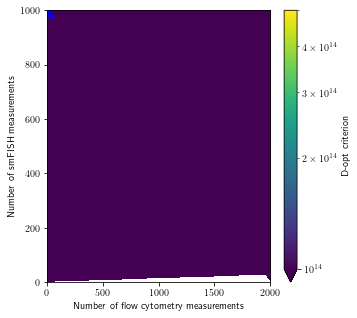

In [52]:
import matplotlib.colors as colors
fig = plt.figure()
ax = fig.add_subplot()
fig.set_size_inches(5,5)
mixture_plot = ax.pcolorfast(obj_values, norm=colors.LogNorm(vmin=1.0E14, vmax=5.0E14))
fig.colorbar(mixture_plot, ax=ax, orientation='vertical', extend='min',
             label=r"D-opt criterion")
ax.scatter(opt_mixture[1], opt_mixture[0], 400, marker='*', color="blue")
ax.set_xlabel("Number of flow cytometry measurements")
ax.set_ylabel("Number of smFISH measurements")
fig.savefig("figs/mixture_dopt.png", bbox_inches="tight", dpi=300)

## Heatmaps for the probability kernels

In [53]:
# fig, axs = plt.subplots(1, 3)
# fig.set_size_inches(9, 2.5)
# fig.set_tight_layout(True)
#
# import matplotlib.colors as colors
#
# C_binom[C_binom<=0.0] = 1.0e-16
# p0 = axs[0].pcolorfast(C_binom[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
#                          cmap=plt.cm.get_cmap("Oranges"))
# fig.colorbar(p0, ax=axs[0], orientation='vertical', extend='min', label=r"Conditional Probability")
#
# C_lowres[C_lowres == 0.0] = 1.0e-16
# p1 = axs[1].pcolorfast(C_lowres[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
#                          cmap=plt.cm.get_cmap("Blues"))
# axs[1].set_ylim([0, 100])
# fig.colorbar(p1, ax=axs[1], orientation='vertical', extend='min', label="Conditional Probability")
#
# p2 = axs[2].pcolorfast(np.arange(0, xmax_flowcyt+1), yeval, C_flowcyt, norm=colors.LogNorm(vmin=1.0E-8, vmax=1.0E-3),
#                          cmap=plt.cm.get_cmap("Greens"))
# axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
# cbar2 = fig.colorbar(p2, ax=axs[2], orientation='vertical', extend='both', label=r"Conditional Probability")
#
#
# for j in range(0,3):
#     axs[j].set_xlabel('True mRNA copy number')
#     axs[j].set_ylabel('Observed number of spots')
# axs[2].set_ylabel('Fluorescence intensity')
#
# models = ['smFISH missing spots', 'smFISH low-resolution images', 'Flow cytometry']
# for j in range(0,3):
#     axs[j].set_title(rf'\textbf{{{models[j]}}}')
#     axs[j].grid()

In [54]:
# fig.savefig('figs/kernel_maps.png', bbox_inches='tight', dpi=200)

